# Alexnet

![Alexnet Architecture](Alexnet_architecture.png "Alexnet")

In [19]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datetime import datetime


In [4]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [5]:
%matplotlib inline

In [6]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.ToTensor() ])

In [7]:
train_dataset = datasets.MNIST(root = 'mnist_data', train=True, transform=transform, download=True)
valid_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([1, 224, 224]) 5


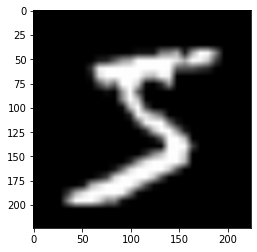

In [8]:
img, label = train_dataset[0]
print(img.shape, label)

plt.imshow(img[0], cmap='gray')

In [9]:
class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
        nn.Linear(in_features=6400, out_features=4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=4096, out_features=10),
    )

  def forward(self, X):
    X = self.feature_extractor(X)
    X = torch.flatten(X, 1)
    logits = self.classifier(X)
    probs = F.softmax(logits, dim=1)
    return logits, probs

In [10]:
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for X, y in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [11]:
def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0

  for X, y in valid_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss

In [14]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device):
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  for epoch in range(0, epochs):
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    train_acc = get_accuracy(model, train_loader, device)
    valid_acc = get_accuracy(model, valid_loader, device)

    print(f'{datetime.now().time().replace(microsecond=0)} ---- '
          f'Epoch: {epoch}\t'
          f'Train Loss: {train_loss:.4f}\t'
          f'Valid Loss: {valid_loss:.4f}\t'
          f'Train Accuracy: {100 * train_acc:.2f}\t'
          f'Valid Accuracy: {100 * valid_acc:.2f}')
      
  plot_losses(train_losses, valid_losses)
  return model, optimizer, (train_losses, valid_losses)


In [13]:
def get_accuracy(model, data_loader, device):
  correct_pred = 0
  n = 0
  with torch.no_grad():
    model.eval()
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)
      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y.size(0)
      correct_pred += (y == predicted_labels).sum()

    return correct_pred.float()/n

def plot_losses(train_losses, valid_losses):
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig,ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color='blue', label='Training loss')
  ax.plot(valid_losses, color='red', label='Validation loss')
  ax.set(title='Loss over epochs',  xlabel='Epoch', ylabel='loss')
  ax.legend()
  fig.show()

  plt.style.use('default')

00:55:02 ---- Epoch: 0	Train Loss: 0.3396	Valid Loss: 0.0877	Train Accuracy: 97.61	Valid Accuracy: 97.56
00:56:29 ---- Epoch: 1	Train Loss: 0.0774	Valid Loss: 0.0688	Train Accuracy: 98.14	Valid Accuracy: 98.03
00:57:55 ---- Epoch: 2	Train Loss: 0.0648	Valid Loss: 0.0522	Train Accuracy: 98.77	Valid Accuracy: 98.55
00:59:21 ---- Epoch: 3	Train Loss: 0.0627	Valid Loss: 0.0451	Train Accuracy: 98.83	Valid Accuracy: 98.74
01:00:48 ---- Epoch: 4	Train Loss: 0.0538	Valid Loss: 0.0337	Train Accuracy: 99.21	Valid Accuracy: 99.07
01:02:14 ---- Epoch: 5	Train Loss: 0.0526	Valid Loss: 0.0329	Train Accuracy: 99.27	Valid Accuracy: 99.11
01:03:40 ---- Epoch: 6	Train Loss: 0.0487	Valid Loss: 0.0391	Train Accuracy: 99.32	Valid Accuracy: 98.98
01:05:06 ---- Epoch: 7	Train Loss: 0.0491	Valid Loss: 0.0485	Train Accuracy: 99.04	Valid Accuracy: 98.86
01:06:32 ---- Epoch: 8	Train Loss: 0.0476	Valid Loss: 0.0473	Train Accuracy: 99.10	Valid Accuracy: 98.89
01:07:58 ---- Epoch: 9	Train Loss: 0.0438	Valid Loss: 0

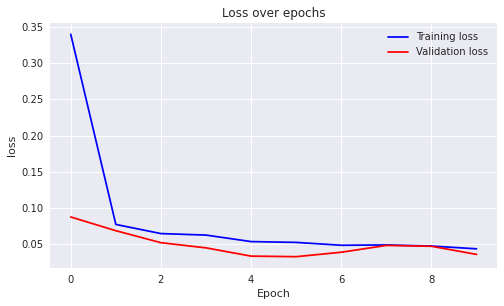

In [20]:

model = AlexNet()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, 10, DEVICE)